# Data Download and Cleaning

We will download SNOTEL data set using the [metloom](https://metloom.readthedocs.io/en/latest/installation.html).

## Download Data

In [2]:
%pip install -q metloom 

In [4]:
from datetime import datetime
from metloom.pointdata import SnotelPointData

ALLOWED_VARIABLES = [
    SnotelPointData.ALLOWED_VARIABLES.SWE,
    SnotelPointData.ALLOWED_VARIABLES.TEMPAVG,
    SnotelPointData.ALLOWED_VARIABLES.SNOWDEPTH,
    SnotelPointData.ALLOWED_VARIABLES.PRECIPITATION,
]

# You can get triplets from: https://wcc.sc.egov.usda.gov/nwcc/yearcount?network=sntl&state=&counttype=statelist

snotel_point = SnotelPointData(station_id="502:WA:SNTL", name="Green Lake")
data = snotel_point.get_daily_data(
                start_date=datetime(*(2010, 1, 1)),
                end_date=datetime(*(2023, 1, 1)),
                variables=ALLOWED_VARIABLES,
            )

data.info()
data.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 4749 entries, (Timestamp('2010-01-01 08:00:00+0000', tz='UTC'), '502:WA:SNTL') to (Timestamp('2023-01-01 08:00:00+0000', tz='UTC'), '502:WA:SNTL')
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   geometry             4749 non-null   geometry
 1   SWE                  4748 non-null   float64 
 2   SWE_units            4748 non-null   object  
 3   AVG AIR TEMP         4738 non-null   float64 
 4   AVG AIR TEMP_units   4738 non-null   object  
 5   SNOWDEPTH            4748 non-null   float64 
 6   SNOWDEPTH_units      4748 non-null   object  
 7   PRECIPITATION        4745 non-null   float64 
 8   PRECIPITATION_units  4745 non-null   object  
 9   datasource           4749 non-null   object  
dtypes: float64(4), geometry(1), object(5)
memory usage: 551.3+ KB


,,geometry,SWE,SWE_units,AVG AIR TEMP,AVG AIR TEMP_units,SNOWDEPTH,SNOWDEPTH_units,PRECIPITATION,PRECIPITATION_units,datasource
datetime,site,,,,,,,,,,
2010-01-01 08:00:00+00:00,502:WA:SNTL,POINT Z (-121.17093 46.54741 5920.00000),9.2,in,32.18,degF,34.0,in,0.5,in,NRCS
2010-01-02 08:00:00+00:00,502:WA:SNTL,POINT Z (-121.17093 46.54741 5920.00000),9.7,in,29.30,degF,37.0,in,0.3,in,NRCS
2010-01-03 08:00:00+00:00,502:WA:SNTL,POINT Z (-121.17093 46.54741 5920.00000),10.0,in,28.94,degF,38.0,in,0.1,in,NRCS
2010-01-04 08:00:00+00:00,502:WA:SNTL,POINT Z (-121.17093 46.54741 5920.00000),10.1,in,33.80,degF,38.0,in,0.7,in,NRCS
2010-01-05 08:00:00+00:00,502:WA:SNTL,POINT Z (-121.17093 46.54741 5920.00000),10.8,in,36.86,degF,38.0,in,0.1,in,NRCS


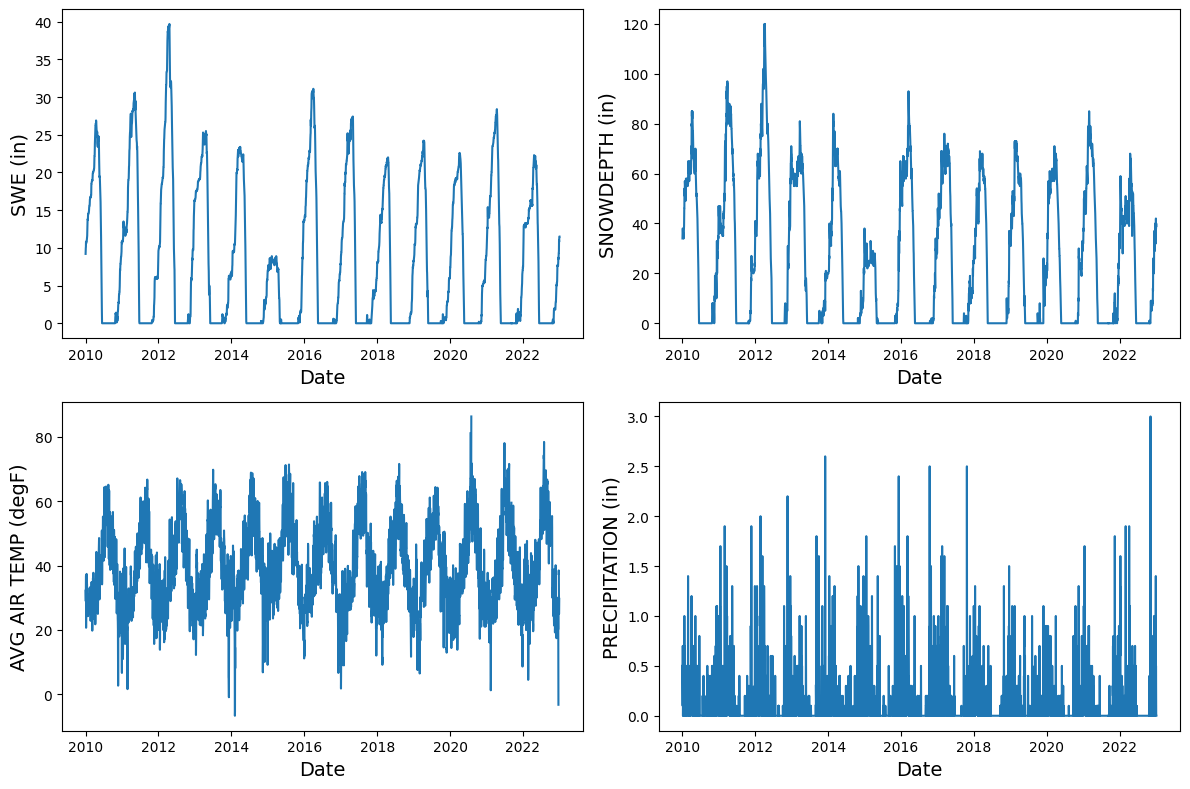

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

for_plotting=data.reset_index()

units={
    "SWE": "in",
    "SNOWDEPTH": "in",
    "AVG AIR TEMP": "degF",
    "PRECIPITATION": "in"
}

variables_to_plot = [
    "SWE", "SNOWDEPTH", "AVG AIR TEMP", "PRECIPITATION"
]

plt.figure(figsize=(12, 8))

for variable in variables_to_plot:
    plt.subplot(2, 2, variables_to_plot.index(variable) + 1)
    plt.plot(for_plotting["datetime"], for_plotting[variable], label=variable)
    plt.ylabel(f"{variable} ({units[variable]})", fontsize=14)
    plt.xlabel("Date", fontsize=14)

plt.tight_layout()
plt.show()

In [16]:
for_plotting.isnull().sum() # Check for missing values

datetime                0
site                    0
geometry                0
SWE                     1
SWE_units               1
AVG AIR TEMP           11
AVG AIR TEMP_units     11
SNOWDEPTH               1
SNOWDEPTH_units         1
PRECIPITATION           4
PRECIPITATION_units     4
datasource              0
dtype: int64

## Some Background

At a given point, snow depth ($h_s$) is related to Snow Water Equivalent (SWE) by the local bulk density ($\rho_b$):

$$
\text{SWE} = h_s \frac{\rho_b}{\rho_w}
$$

where depth is measured in centimeters, density in grams per centimeters cubed, $\rho_w$ is the density of water (1 g cm $^{-3}$), and SWE is measured in centimeters of water. As such,

\begin{align*}
\text{SWE} & = h_s \times \frac{\rho_b}{1}\\
& = h_s \times \rho_b \\
\rho_b & = \frac{\text{SWE}}{h_s}
\end{align*}

In [46]:
clean_df=(
    for_plotting
    .assign(
        swe=lambda x: x.SWE.map(lambda y: y*2.54 if y is not None else None),
        snowdepth=lambda x: x.SNOWDEPTH.map(lambda y: y*2.54 if y is not None else None),
        precipitation=lambda x: x.PRECIPITATION.map(lambda y: y*2.54 if y is not None else None),
        tempavg=lambda x: x['AVG AIR TEMP'].map(lambda y: (y-32)*5/9 if y is not None else None)
    )
    .set_index('datetime')
    .assign(
        precip_7_days_avg=lambda x: x.precipitation.shift().rolling(window="7D", min_periods=7).mean(),
        tempavg_7_days_avg=lambda x: x.tempavg.shift().rolling(window="7D", min_periods=7).mean(),
    )
    .filter(["datetime", "swe", "snowdepth", "tempavg_7_days_avg", "precip_7_days_avg"])
    .dropna()
    .query(
        "snowdepth != 0 and swe != 0 and "
        "snowdepth > 5 and swe > 3"
    )
    .assign(snowdensity=lambda x: x.swe / x.snowdepth)
)

clean_df.head()

,swe,snowdepth,tempavg_7_days_avg,precip_7_days_avg,snowdensity
datetime,,,,,
2010-01-08 08:00:00+00:00,27.178,91.44,-1.414286,0.653143,0.297222
2010-01-09 08:00:00+00:00,27.686,91.44,-1.528571,0.544286,0.302778
2010-01-10 08:00:00+00:00,27.686,91.44,-0.971429,0.435429,0.302778
2010-01-11 08:00:00+00:00,27.686,88.90,-0.557143,0.399143,0.311429
2010-01-12 08:00:00+00:00,27.686,88.90,-0.271429,0.181429,0.311429


In [47]:
# let's store data for later use

import os

os.makedirs("data", exist_ok=True)
clean_df.to_csv("data/clean_data.csv", index=False)